# Import Libraries

In [1]:
import healpy as hp
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
from src.info_extractor import InfoExtractor
from src.patch_analyser import PatchAnalyser
from src.fullsky_analyser import FullSkyAnalyser
from analysis import KappaAnalyser
from src.patch_processor import PatchProcessor
from src.utils import load_config, filter_config, setup_logging

# Setup the environment

In [3]:
workdir = Path("/lustre/work/akira.tokiwa/Projects/LensingSSC")
config_file = workdir / "configs" / "config_default.yaml"
sample_dir = workdir / "data" / "tiled" / "proc2048_nc1024_size625_nsteps60_s401_10tiled"

In [4]:
config = load_config(config_file)
setup_logging()

In [5]:
filtered_config_pp = filter_config(config, PatchProcessor)
pp = PatchProcessor(**filtered_config_pp)

filtered_config_pa = filter_config(config, PatchAnalyser)
pa = PatchAnalyser(pp, **filtered_config_pa)

filtered_config_fsa = filter_config(config, FullSkyAnalyser)
fsa = FullSkyAnalyser(**filtered_config_fsa)

ka = KappaAnalyser(sample_dir, pa, fsa)

2024-10-18 13:22:55,095 - INFO - Initialized PatchProcessor with npatch=273, patch_size_deg=10.0, xsize=2048
2024-10-18 13:22:55,096 - INFO - Initializing FlatPatchAnalyser with nbin=15, lmin=300, lmax=3000
2024-10-18 13:22:55,097 - INFO - FullSkyAnalyser initialized with nside=8192, nbin=15, lmin=300, lmax=3000
2024-10-18 13:22:55,108 - INFO - Output directories created


In [9]:
# ka.analyse()

# Sample run

In [11]:
patch_kappa_path = ka.patch_kappa_paths[0]
tmp_kappa_patches = np.load(patch_kappa_path)
tmp_snr_paths = ka._filter_paths_by_input(ka.patch_snr_paths, patch_kappa_path)
patch_snr_path = tmp_snr_paths[0]
fname = Path(patch_snr_path).name.replace('patches', 'analysis')
snr_patches = np.load(patch_snr_path)
data = ka.pa.process_patches(tmp_kappa_patches, snr_patches)

In [23]:
# sk0, sk1, sk2, kur0, kur1, kur2, kur3 are scalars
# all the other values are the same length: pa.nbin
# The order of the values is equilateral, isosceles, squeezed, clkk,
#            sk0, sk1, sk2, kur0, kur1, kur2, kur3,
#            pdf_vals, peaks, minima, v0, v1, v2

# separate the data
equilateral = data[:, pa.nbin * 0:pa.nbin * 1]
isosceles = data[:, pa.nbin * 1:pa.nbin * 2]
squeezed = data[:, pa.nbin * 2:pa.nbin * 3]
clkk = data[:, pa.nbin * 3:pa.nbin * 4]
sk0 = data[:, pa.nbin * 4]
sk1 = data[:, pa.nbin * 4 + 1]
sk2 = data[:, pa.nbin * 4 + 2]
kur0 = data[:, pa.nbin * 4 + 3]
kur1 = data[:, pa.nbin * 4 + 4]
kur2 = data[:, pa.nbin * 4 + 5]
kur3 = data[:, pa.nbin * 4 + 6]
pdf_vals = data[:, pa.nbin * 4 + 7:pa.nbin * 5 + 7]
peaks = data[:, pa.nbin * 5 + 7:pa.nbin * 6 + 7]
minima = data[:, pa.nbin * 6 + 7:pa.nbin * 7 + 7]
v0 = data[:, pa.nbin * 7 + 7:pa.nbin * 8 + 7]
v1 = data[:, pa.nbin * 8 + 7:pa.nbin * 9 + 7]
v2 = data[:, pa.nbin * 9 + 7:pa.nbin * 10 + 7]

In [14]:
global_std = np.std(snr_patches)

In [15]:
from lenstools import ConvergenceMap
from astropy import units as u

patch_pixels = tmp_kappa_patches[0]
patch_snr_pixels = snr_patches[0]

# Process kappa (convergence) map
conv_map = ConvergenceMap(patch_pixels, angle=pa.patch_size * u.deg)
equilateral, isosceles, squeezed = pa._compute_bispectrum(conv_map)
clkk = pa._compute_power_spectrum(conv_map)
sk0, sk1, sk2, kur0, kur1, kur2, kur3 = pa._compute_moments(conv_map, global_std)

# Process SNR map
snr_map = ConvergenceMap(patch_snr_pixels/global_std, angle=pa.patch_size * u.deg)
pdf_vals = pa._compute_pdf(snr_map)
peaks = pa._compute_peak_statistics(snr_map, is_minima=False)
minima = pa._compute_peak_statistics(snr_map, is_minima=True)
v0,v1,v2 = pa._compute_minkowski_functionals(snr_map)

# Check the output files

### indivisual run

In [13]:
sample_path = "/lustre/work/akira.tokiwa/Projects/LensingSSC/data/bigbox/rfof_proc131072_nc6144_size3750_nsteps60lin_ldr0_rcvfalse_fstnone_pnf2_lnf2_s100_dhf1.0000_tiled0.20_fll_elllim_10000_npix_8192_rfofkdt_8/analysis_patch/analysis_zs0.5_s100_oa10_noiseless_sl2.npy"

In [14]:
data = np.load(sample_path)

### batch run

In [99]:
sample_bigbox_path = "/lustre/work/akira.tokiwa/Projects/LensingSSC/output/patch_stats_bigbox_oa10_noiseless_sl2.npy"
sample_tiled_path = "/lustre/work/akira.tokiwa/Projects/LensingSSC/output/patch_stats_tiled_oa10_noiseless_sl2.npy"

In [100]:
data_tiled = np.load(sample_tiled_path, allow_pickle=True).item()
data_bigbox = np.load(sample_bigbox_path, allow_pickle=True).item()

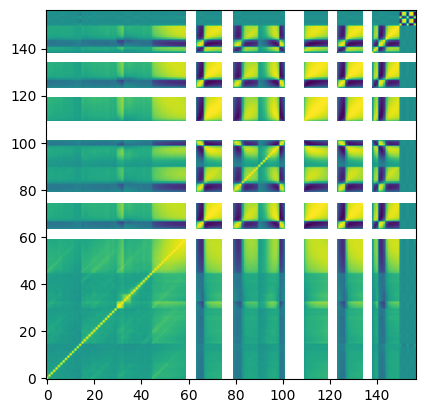

In [101]:
plt.imshow(data_tiled[0.5]["corr"], origin="lower", vmin=-1, vmax=1)

### Comparison with halofit

In [93]:
halofit_dir = Path("/lustre/work/akira.tokiwa/Projects/LensingSSC/data/halofit")
halofit_paths = sorted(list(halofit_dir.glob("*.npz")))

In [94]:
def discretize_cl(cl_cont,lmin=300, lmax=3000, nbin=15):
        l_edges = np.logspace(np.log10(lmin), np.log10(lmax), nbin + 1)
        ell = np.arange(2, lmax + 1)
        bin_indices = np.digitize(ell, l_edges, right=True)

        # Exclude out-of-range indices
        valid = (bin_indices > 0) & (bin_indices <= nbin)
        bin_indices = bin_indices[valid]
        cl_values = cl_cont # Assuming cl_cont starts at ell=0

        cl_sum = np.bincount(bin_indices, weights=cl_values[valid], minlength=nbin + 1)
        counts = np.bincount(bin_indices, minlength=nbin + 1)

        with np.errstate(divide='ignore', invalid='ignore'):
            cl_disc = np.divide(cl_sum, counts, where=counts > 0)[1:nbin + 1]

        return cl_disc

In [95]:
# Fullsky area in square degrees 
fs_area = 4 * np.pi * (180 / np.pi) ** 2
f_sky = 100 / fs_area

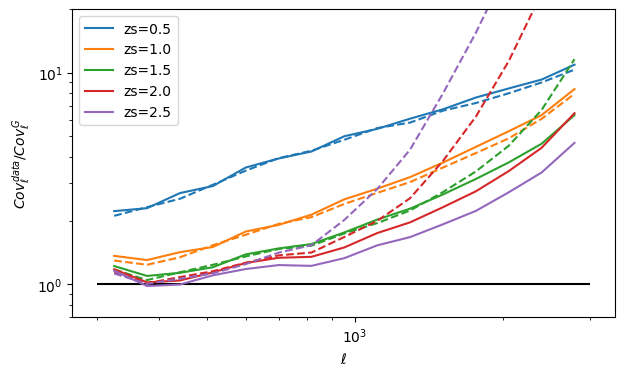

In [115]:
lmin, lmax, nbin = 300, 3000, 15
l_edges = np.logspace(np.log10(lmin), np.log10(lmax), nbin + 1)
ell = (l_edges[1:] + l_edges[:-1]) / 2
nmodes = np.diff(np.log(l_edges))
zs_list = [0.5, 1.0, 1.5, 2.0, 2.5]
colors = {zs: color for zs, color in zip(zs_list, ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"])}

fig = plt.figure(figsize=(7, 4))
plt.hlines(1, lmin, lmax, color="black")
for halofit_path in halofit_paths[:-1]:
    data_hf = np.load(halofit_path)
    zs = InfoExtractor.extract_redshift_from_path(str(halofit_path))
    ell_cont = data_hf["ell"]
    clkk = data_hf["clkk"]* ell_cont * (ell_cont + 1) / (2 * np.pi)
    clkk = discretize_cl(clkk) 
    plt.plot(ell,data_tiled[zs]["diags"][45:60] /(clkk**2 / (f_sky * nmodes * ell**2)) , linestyle="--", color=colors[zs])
    plt.plot(ell,data_bigbox[zs]["diags"][45:60] /(clkk**2 / (f_sky * nmodes * ell**2)) , label=f"zs={zs}", color=colors[zs])


plt.ylim(0.7, 20)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$Cov_{\ell}^{data} / Cov_{\ell}^{G}$")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()

In [110]:
var_gaussian = np.array([2.26475245e-10, 2.16173445e-10, 1.97849882e-10, 1.72439254e-10,
       1.45688920e-10, 1.22894502e-10, 1.03271319e-10, 8.68930781e-11,
       7.44155066e-11, 6.47413916e-11, 5.72538998e-11, 5.11710458e-11,
       4.58278803e-11, 4.07273692e-11, 3.55834475e-11, 3.03158161e-11])